<a href="https://colab.research.google.com/github/Dac196/VisionComputer/blob/main/Clasificador_imagenes2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Red Neuronal Clasificadora de Imágenes


#### Introducción

En el presente código se implementa una red neuronal convoluciona (CNN) para la clasificación de imágenes a partir del dataset CIFAR-10, el cual posee 60000 imágenes de 10 elementos diferentes. Luego se prueba con una galería de imágenes de autoría propia con el fin de realizar una verificación del modelo.

#### Diseño

##### Selección del conjunto de datos

Para el diseño de la red neuronal se debe considerar en primera instacia la cantidad de datos de entrada que tendrá. Esto dependerá del número de elementos (pixeles) que tendrá las imágenes del respectivo dataset. Asimismo, de las etiquetas disponibles en el dataset, se podrán definir el número neuronas de salida.

Para el entranamiento del modelo, se utiliza el dataset de uso abierto CIFAR-10 que contiene unas 60000 imágenes de 32x32 pixeles a color y que contiene 10 clases diferentes. Este dataset cuenta con 50000 imágenes de entrenamiento y otras 10000 de prueba.

Las imágenes se encuentran divididas en las siguientes categorías:

- Avión
- Carro
- Ave
- Gato
- Ciervo
- Perro
- Rana
- Caballo
- Barco
- Camión


In [ ]:
##### Importación de librerías a utilizar
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2 as cv


In [ ]:
### Importación del dataset CIFAR-10
# Cargar el conjunto de datos CIFAR-10
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()


A continuación, se normalizan los datos de manera que estos se encuentren en un rango entre 0 y 1. Para esto se divide por 255 los respectivos arrays.
Nótese que cada valor varía desde 0 a 255 (2^8 valores) donde 0 es la intensidad mínima y 255 representa el brillo máximo.

In [ ]:
### Se normalizan los datos de manera que cada uno se encuentre entre un rango de 0 a 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [ ]:
### Se define una lista con los nombres de las clases en el respectivo orden
class_names = ['Avión','Carro','Ave', 'Gato', 'Ciervo', 'Perro', 'rana', 'Caballo', 'Barco', 'Camión']

A continuación, se presenta 16 imágenes del conjunto de datos.

Tal y como se puede observar son imágenes de muy baja resolución (32x32 pixeles) de tipo RGB. Es natural que con tan baja resolución se pierdan muchos detalles, no obstante, para fines académicos se utilizará este dataset.

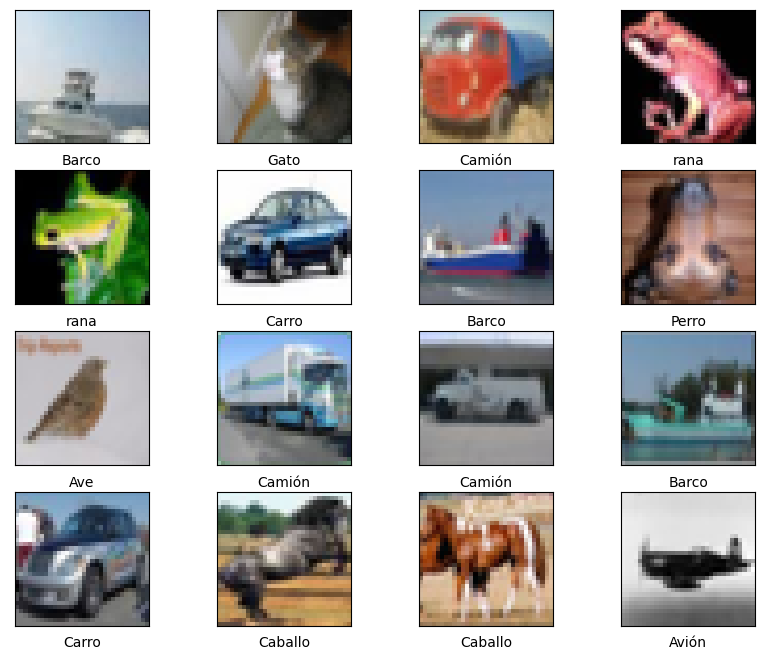

In [ ]:
### Se grafíca un subplot con 16 imágenes
plt.figure(figsize = (10,8))
n = 0
for i in range(100,116):
    plt.subplot(4, 4, n+1)
    plt.xticks([]) ## No se muestran los ejes para mejor visualización
    plt.yticks([])
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
    n+=1

plt.show()


##### Selección de hiérparámetros de la red
Teniendo en cuenta que se trata de un conjunto de datos de 32x32 pixeles a color RGB se debe considerar lo siguientes:

- *Capa de entrada* debe contar con 32x32x3 neuronas (3072) de manera que cada pixel quede representado dentro de la red
- Deberá contar con una *capa de salida* de 10 neuronas de manera que cada una represente las respectivas etiquetas del conjunto de datos (en este caso 10 categorías diferentes)
- Respecto a las *capas ocultas*, teniendo en cuenta que se el ejercicio involucra el reconocimiento de imágenes, las redes convolucionales (CNN) presenta un adecuado comportamiento
- Por lo tanto, las capas ocultas se definen con una activación "ReLu" en tanto que para la capa de salida se define una función de tipo "Softmax", la cual presenta un adecuado comportamiento ante la optimización de la red mediante el descenso de gradiente.
- Las capas ocultas se han considerado de tipo convolucional, las cuales han probado ser óptimas para la detección de patrones, especialmente para procesamiento de imágenes. Cada una de estas capas posee un número especificado de filtros y de Kernel. A continuación, se presenta un ejemplo de lo que hace un único filtro (convolución) de 3x3. Nótese que cada filtro logra resaltar patrones diferentes
![imagen.png](attachment:37d31ae6-b647-43a0-bc79-0a577df3fc5f.png)

- Luego de cada capa convolucional se agrega una capa de MaxPoling, la cual hará una operación matricial de 2x2 a partir de la salida de la red neuronal
- Nótese que la estructura definida a continuación, proviene de una múltiple serie de pruebas (ensayo y error) de manera de conseguir una precisión y un optimización más rápida de la red neuronal

A continuacón se presenta una arquitectura básica de una CNN para el reconocimiento de imágenes que se asemeja la implementada en el presente ejercicio.

![imagen.png](attachment:6e0ec091-1253-45d2-8210-a8fc16006520.png)


In [ ]:
### Definición del modelo (luego de múltiples ensayos con diferentes configuraciones)
model = models.Sequential()
## Capa convolucional con 32 filtro y un kernel de 3x3
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3))) #Capa de entrada y una capa convolucional de 32 filtro
model.add(layers.MaxPooling2D((2,2))) ## Capa de MaxPooling
model.add(layers.Conv2D(64, (3,3), activation = 'relu')) # Capa convolucional con 64 filtro
model.add(layers.MaxPooling2D((2,2)))  ## Capa de MaxPooling
model.add(layers.Conv2D(64, (3,3), activation = 'relu')) # Capa convolucional con 64 filtro
model.add(layers.Flatten()) ### Capa para aplanar todos los datos resultantes en un única dimensión
model.add(layers.Dense(64, activation='relu')) ### Capa "fully conected"
model.add(layers.Dense(10, activation = 'softmax')) ## Capa con 10 salidas (10 categorías)

Existen varios tipos de optimizadores (destinados a reducir reducir al máximo la función de coste), no obstante, el de tipo "adam" resulta apropiado en el presente ejercicio.

In [ ]:
### Se compila el modelo y se define el tipo de optimizador y la métrica de evaluación y pérdida (loss)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## Entrenamiento del modelo
model.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.5282 - accuracy: 0.4421 - val_loss: 1.3145 - val_accuracy: 0.5254
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.1623 - accuracy: 0.5868 - val_loss: 1.0651 - val_accuracy: 0.6194
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0087 - accuracy: 0.6439 - val_loss: 0.9781 - val_accuracy: 0.6611
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9167 - accuracy: 0.6777 - val_loss: 0.9657 - val_accuracy: 0.6654
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8505 - accuracy: 0.7007 - val_loss: 0.9574 - val_accuracy: 0.6642
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7960 - accuracy: 0.7207 - val_loss: 0.8810 - val_accuracy: 0.6981
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7450 - accuracy: 0.7384 - val_loss: 0.8880 -

In [ ]:
# ## Métricas de evaluación del modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8479 - accuracy: 0.7128
Loss: 0.8478612303733826
Accuracy: 0.7128000259399414


In [ ]:
### Se guarda el modelo para no tener que volverlo a correr cada vez
model.save('clasificador.model')

INFO:tensorflow:Assets written to: clasificador.model\assets


INFO:tensorflow:Assets written to: clasificador.model\assets


In [ ]:
#Se carga el modelo guardado
model = models.load_model('clasificador.model')


#### Resultados
Como se presenta en la celdas anteriores, el modelo presenta una precisión cercana al 70% con las imágenes del set de prueba

A continuación, se presente la respectiva matriz de confusión

In [ ]:
# #### Matriz de confusión ####
# # Obtener las predicciones del modelo para el conjunto de prueba
y_pred = np.argmax(model.predict(x_test), axis=1)
# # Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

313/313 [==============================] - 1s 4ms/step


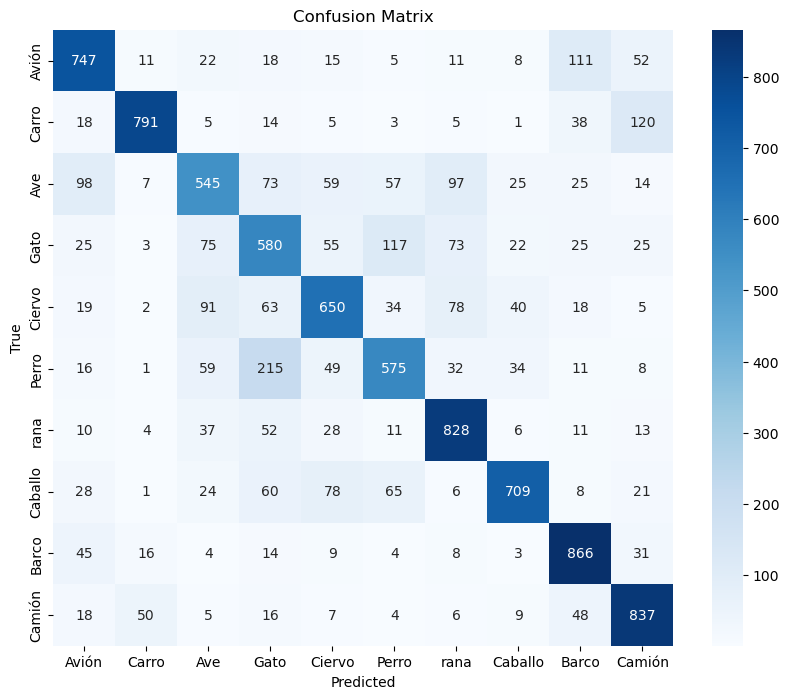

In [ ]:
## graficación de la matriz de confusión mediante la librería sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Considerando la baja resolución de las imágenes y, por lo tanto, la pérdida de información y de destalles que puede analizar la red, se considera que una precisión del 70% resulta adecuada.

#### Pruebas con Dataset personalizado
Se ha creado un conjunto de imágenes de prueba (de autoría del equipo de trabajo) a fin de observar el comportamiento del modelo.
Las imágenes tomadas en su mayoría con cámaras de celular han sido redimensionadas mediante programas especializados a 32x32 para poder ser ingresadas al modelo.
A continuación se grafican algunas de las imágenes.

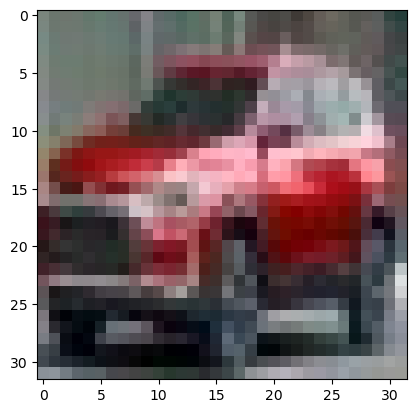

numpy.ndarray

In [ ]:
### datos de prueba de galería propia
#path = "C:\\Users\\dgome\\Semana _7\\avion.jpg"
path = "C:\\Users\\dgome\\Semana _7\\test\\_completo\\Carro 11.jpg"
path2 = "C:\\Users\\dgome\\Semana _7\\test\\data_set.csv"
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img, cmap=plt.cm.binary)
plt.show()
cv.waitKey(0)
cv.destroyAllWindows()
type(img)


In [ ]:
prediction = model.predict(np.array([img])/255)
index = np.argmax(prediction)
print(f'La imagen corresponde a: {class_names[index]}')

1/1 [==============================] - 0s 18ms/step
La imagen corresponde a: Carro


In [ ]:
print(prediction)

[[2.6956702e-06 9.9853361e-01 2.9017092e-10 3.3306560e-09 5.1703702e-10
  1.6612822e-09 9.4715358e-10 1.3277197e-09 5.6046156e-07 1.4630458e-03]]


A continuación, se prueba con un dataset de autoría propia

In [ ]:
import pandas as pd
data = pd.read_csv(path2, sep=';')
data.head()

,Labels,Pixels
0,2,113 105 103 82 74 72 193 185 183 195 187 184 1...
1,2,105 125 56 118 140 57 112 139 36 124 155 38 14...
2,2,161 187 34 157 184 29 153 180 25 150 180 22 14...
3,2,115 145 95 116 145 97 118 147 99 119 148 102 1...
4,2,110 122 86 110 120 85 110 117 84 114 117 90 11...


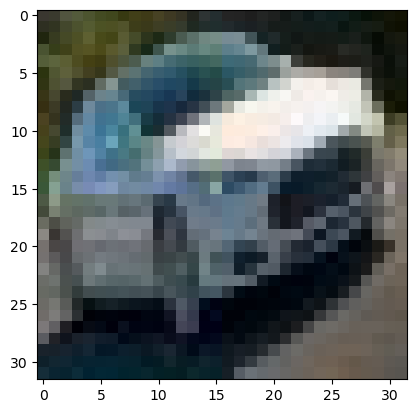

In [ ]:
import pandas as pd

image_size = (32, 32, 3)
def load():
    data = pd.read_csv(path2, sep = ';')
    pixels = data['Pixels'].tolist()
    width, height, depth= 32, 32, 3 # add depth 3 if RGB image
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face[:3072]).reshape(width, height, depth) #add depth if RGB image
        a = face
        face = np.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    A = faces
    faces = np.expand_dims(faces, -1)
    return faces, A

faces,A = load()
plt.imshow(A[40].astype("uint8"))



In [ ]:
data = pd.read_csv(path2, sep = ';')
y_values = data['Labels']
type(y_values)
y_values
A.shape
A /=255.0

In [ ]:
y_pred = np.argmax(model.predict(A), axis=1)
y_pred

3/3 [==============================] - 0s 5ms/step


array([0, 6, 2, 2, 0, 2, 8, 2, 6, 9, 8, 0, 9, 0, 0, 0, 1, 8, 8, 8, 8, 5,
       7, 6, 7, 7, 7, 4, 7, 9, 9, 9, 0, 9, 6, 9, 9, 8, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 7, 3, 5, 8, 3, 3, 3, 3, 3, 0, 3, 5, 3, 6, 2, 5, 0,
       3, 4, 5, 5, 5, 5, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

In [ ]:
cm = confusion_matrix(y_values, y_pred)
class_names = ['Avión','Carro','Ave', 'Gato', 'Ciervo', 'Perro', 'rana', 'Caballo', 'Barco', 'Camión']

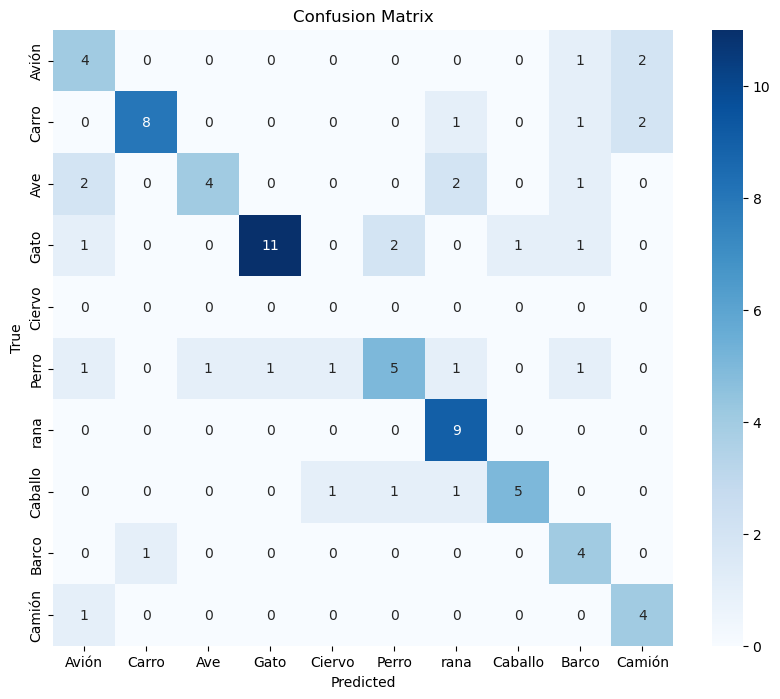

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ## Métricas de evaluación del modelo
loss, accuracy = model.evaluate(A, y_values)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 0s 6ms/step - loss: 0.9229 - accuracy: 0.6585
Loss: 0.9229328632354736
Accuracy: 0.6585366129875183


### Conclusiones

- Se ha construido una red neuronal convolucional (CNN) para la clasificación de 10 categorías diferentes.
- Esta red ha sudo entrenada con el conjunto de datos CIFAR 10, el cual tiene 60000 imágenes (10k de prueba) con una resolución 32x32 de tipo RGB.
- A partir del dataset de entrenamiento se ha definido una estructura básica para la red neuronal como: capas de entrada (dependiente del número de pixeles) y de salida (dependientes del número de categorías)
- Para el resto de hiperparámetros como: número de capas convolucionales, kernels de cada convolución, tamaño de MaxPooling, epochs, tipo de optimizador, entre otros, se modificaron hasta llegar a un resultado de precisión razonable (en este caso 70%).
- Se contruyó una matriz de confusión a partir del dataset de prueba obteniendo resultados relativamente buenos, no obstante, es de resaltar que la resolución de la imágenes disponibles en el dataset resulta ser muy baja, por lo que es posible que muchos detalles o rasgos que caracterizan algún objeto no puedan ser identificados correctamente.
- Nótese que este ejercicio resulta ser de tipo académico, por lo que la resolución de la imágenes no resulta ser un problema. En caso de aplicaciones reales en donde se requiera verifica con detalle determinadas características, se deberán utilizar conjuntos de entrenamiento con mayor resolución derivando en tiempos computacionales mucho mayores.
- Se contruyó un dataset personal en su mayoría con imágenes propias, en donde se pre-procesaron para obtener un tamaño de 32x32 pixeles y pder ser ingresadas a la red neuronal de manera de determinar las salidas.
- En el caso de la imágenes propias se obtuvo una precisión del 60%, no obstante, se debe considerar lo anterior: baja resolución de la imágenes que no permiten reconocer patrones fundamentales. Por lo tanto, considerando la baja resolución de la imágenes se puede decir que existe una precisión razonable.

Referencias:

- https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/
- Zafar Iffat, Hands-On Convolutional Neural Networks with Tensorflow, 2018